In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima


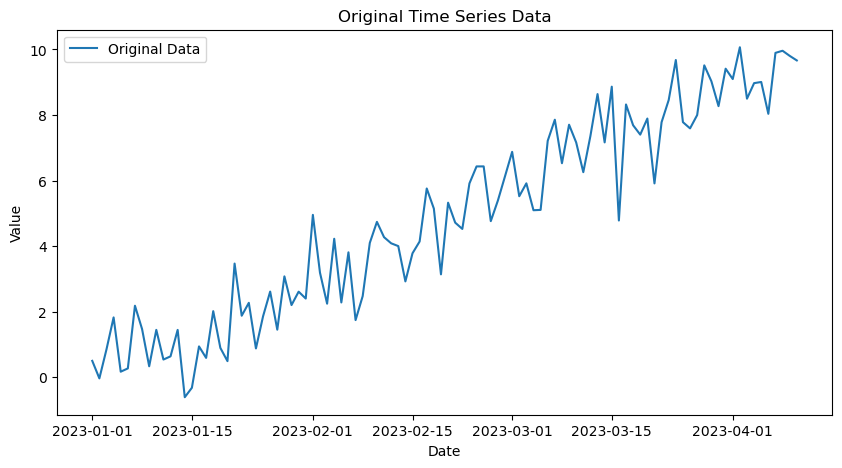

In [23]:
# Step 1: Create synthetic non-stationary time series data
np.random.seed(42)
dates = pd.date_range(start='2023-01-01', periods=100, freq='D')
values = np.random.randn(100) + np.arange(100) * 0.1  # Trend + random noise
data = pd.Series(values, index=dates)

# Step 2: Visualize the original data
plt.figure(figsize=(10, 5))
plt.plot(data, label='Original Data')
plt.title('Original Time Series Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()


In [24]:
# Step 3: Check for stationarity using ADF test
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    return result[1]

# Check stationarity
adf_p_value = adf_test(data)
if adf_p_value > 0.05:
    print("\nThe time series is likely non-stationary (consider differencing).")
else:
    print("\nThe time series is likely stationary.")


ADF Statistic: -0.15026113477284184
p-value: 0.9441964694670332

The time series is likely non-stationary (consider differencing).


In [25]:
# Step 4: Differencing the data if non-stationary
if adf_p_value > 0.05:
    data_diff = data.diff().dropna()  # First-order differencing
    print("Differencing applied.")
else:
    data_diff = data


Differencing applied.


In [26]:
# Step 5: Fit ARIMA model using auto_arima
model = auto_arima(data_diff, seasonal=False, stepwise=True, trace=True)

# Step 6: Summary of the model
print(model.summary())


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=295.161, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=334.882, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=311.006, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=292.635, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=294.181, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=294.031, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.41 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 1.079 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   99
Model:               SARIMAX(0, 0, 1)   Log Likelihood                -144.318
Date:                Thu, 03 Oct 2024   AIC                            292.635
Time:                        16:40:18   BIC         

In [28]:
# Step 7: Make predictions (on differenced data)
n_periods = 10  # Number of periods to predict
forecast_diff, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)
forecast_diff,conf_int

(2023-04-11   -0.130548
 2023-04-12    0.000000
 2023-04-13    0.000000
 2023-04-14    0.000000
 2023-04-15    0.000000
 2023-04-16    0.000000
 2023-04-17    0.000000
 2023-04-18    0.000000
 2023-04-19    0.000000
 2023-04-20    0.000000
 Freq: D, dtype: float64,
 array([[-2.16119592,  1.90009896],
        [-2.47712718,  2.47712718],
        [-2.47712718,  2.47712718],
        [-2.47712718,  2.47712718],
        [-2.47712718,  2.47712718],
        [-2.47712718,  2.47712718],
        [-2.47712718,  2.47712718],
        [-2.47712718,  2.47712718],
        [-2.47712718,  2.47712718],
        [-2.47712718,  2.47712718]]))

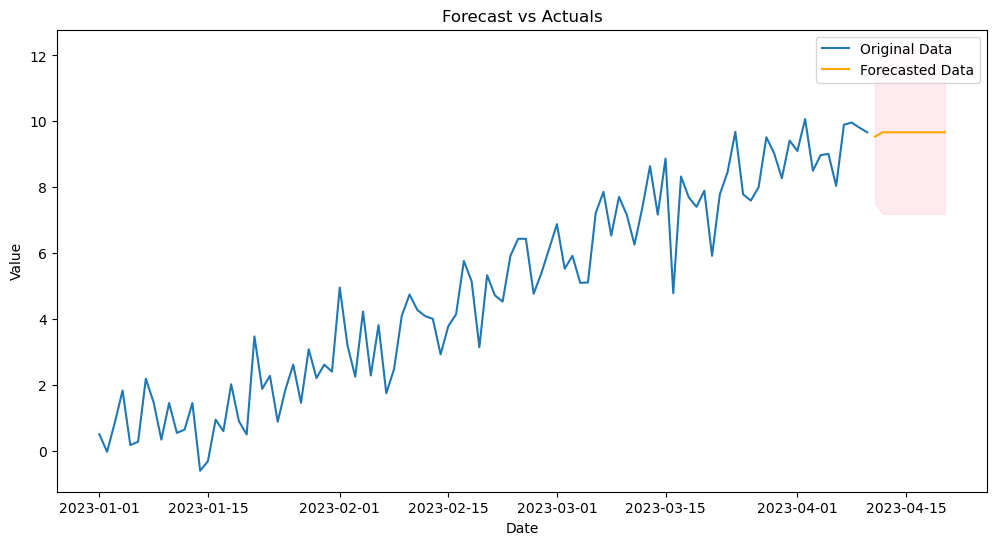

In [29]:
# Step 8: Re-integrate the predictions to the original scale
last_observed_value = data.iloc[-1]  # Last value of original data
forecast = last_observed_value + forecast_diff  # Add last observed value to the forecasted differences

# Step 9: Plot the predictions
plt.figure(figsize=(12, 6))
plt.plot(data, label='Original Data')
plt.plot(pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=n_periods, freq='D'), 
         forecast, label='Forecasted Data', color='orange')
plt.fill_between(pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=n_periods, freq='D'), 
                 conf_int[:, 0] + last_observed_value, conf_int[:, 1] + last_observed_value, 
                 color='pink', alpha=0.3)
plt.title('Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()
